<a href="https://colab.research.google.com/github/Emmanuel461/Sowing_harvest_predictions/blob/main/Modelado_siembra_2022_planet_k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de siembra año 2022


In [ ]:
# Install the dependencies
!pip install geopandas rasterio torchsummary tifffile imagecodecs gdal rasterstats pandas openpyxl torchsummary seaborn torchviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import rasterio
from datetime import datetime
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from rasterio import features
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torchsummary import summary
import tifffile
import imagecodecs
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut


# Define the date range for uploading images (July 1, 2022 to February 1, 2023)
start_date = datetime(2022, 7, 1)
end_date = datetime(2023, 1, 30)


# File paths (please consider that this notebook is for revision, this data is in the Google Drive of the main author)
shapefile_path = '/content/drive/MyDrive/TF_data/DataIn/Parcelas_poligono.geojson'
image_folder_path = '/content/drive/MyDrive/TF_data/Planet_images'  #  Path with the images


# Read the geodataframe 
gdf = gpd.read_file(shapefile_path)

# Define the dates of sowing or harvest dates for 2022 or 2023 (we run all the models in the same notebook)
# 2022
sowing_dates = {
    1: '27/09/2022',
    2: '23/09/2022',
    3: '28/09/2022',
    4: '25/08/2022',
    5: '17/09/2022'
}


# harvest_dates = {
#     1: '30/11/2022',
#     2: '15/12/2022',
#     3: '09/12/2022',
#     4: '15/12/2022',
#     5: '16/12/2022'
# }


# 2023
# sowing_dates = {
#     1: '30/08/2023',
#     2: '15/09/2023',
#     3: '15/09/2023',
#     4: '15/09/2023',
#     5: '15/09/2023'
# }

# Define harvest dates
# harvest_dates = {
#     1: '28/11/2023',
#     2: '12/12/2023',
#     3: '28/11/2023',
#     4: '12/12/2023',
#     5: '12/12/2023'
# }

# Convert planting dates to days from a base date
base_date = datetime(2022, 7, 1) # Or (2023,7,1)
sowing_dates_days = {loc_id: (datetime.strptime(date_str, '%d/%m/%Y') - base_date).days for loc_id, date_str in sowing_dates.items()}

# Convert the `sowing_dates_days` dictionary into a DataFrame for joining
sowing_dates_df = pd.DataFrame(list(sowing_dates_days.items()), columns=['location_id', 'sowing_date_days'])

# Ensure both 'location_id' columns are of the same type
gdf['location_id'] = gdf['location_id'].astype(int)

# Perform a join between the `GeoDataFrame` and the `sowing_dates_df`
gdf = gdf.merge(sowing_dates_df, on='location_id', how='left')

# Verify the join was performed correctly
print("GeoDataFrame después del merge:")
print(gdf.head())

# Load the list of image paths (.tif or .tiff)
image_paths = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.tif', '.tiff'))])

# Filter images within a date range
def filter_images_by_date_range(image_paths, start_date, end_date):
    filtered_paths = []
    for path in image_paths:
        filename = os.path.basename(path)  # Get the file name
        filename_no_ext, _ = os.path.splitext(filename)  # Remove the .tif extension

        parts = filename_no_ext.split('_')  # Split by underscores (_)
        if len(parts) >= 3:
            file_date_str = parts[2]  # The third segment should contain the date: '2022-11-04'
            try:
                # Convert the date string to a datetime object
                file_date = datetime.strptime(file_date_str, '%Y-%m-%d')
                # Only include if the date is within the range
                if start_date <= file_date <= end_date:
                    filtered_paths.append(path)
            except ValueError:
                print(f"Error al extraer la fecha del archivo {filename}")
                continue
        else:
            print(f"Formato de nombre de archivo incorrecto: {filename}")
    return filtered_paths

# Search bands by name
def select_band_by_name(src, band_names, target_band_names):
    band_indices = []
    for target_band_name in target_band_names:
        if target_band_name in band_names:
            band_index = band_names.index(target_band_name) + 1  # rasterio uses 1-based indices
            band_indices.append(band_index)
        else:
            print(f"La banda '{target_band_name}' no se encontró en el archivo. Bandas disponibles: {band_names}")
            return None
    return src.read(band_indices)

# Function to mask images using geometries of interest
def mask_image_with_geometries(image, geometries, transform):
    # Create a mask based on the geometries (areas of interest)
    mask = rasterio.features.geometry_mask(geometries, out_shape=(image.shape[1], image.shape[2]), transform=transform, invert=True)
    # Apply the mask to each band (pixels outside the geometry are masked with -1)
    masked_image = np.where(mask, image, -1)
    return masked_image

# Process full image sequence and add Julian day band
def load_sequence_images(image_paths, gdf, target_band_names=['dias_julianos', 'SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI'], base_date=datetime(2022, 7, 1)):
    sequence = []
    if len(image_paths) == 0:
        print("No se encontraron imágenes para el rango de fechas especificado.")
        return None

    for image_path in image_paths:
        print(f"Cargando y enmascarando imagen: {image_path}")

        # Extract the image date from the filename (without the .tif extension)
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)  # Separate the name and extension
        parts = filename_no_ext.split('_')  # Separate by underscore '_'

        if len(parts) < 3:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        image_date_str = parts[2]  # This should contain the date, e.g., '2022-09-23'

        try:
            # Convert the date string to a datetime object
            image_date = datetime.strptime(image_date_str, '%Y-%m-%d')
            # Calculate Julian days
            julian_days = (image_date - base_date).days
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        with rasterio.open(image_path) as src:
            band_names = list(src.descriptions)  # Get the band names
            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])  # Skip 'dias_julianos' when selecting bands

            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[np.isnan(selected_bands)] = -1

                # Create a Julian days band with the same spatial size as the images
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenate the Julian days band with the selected bands
                stacked_bands = np.vstack((julian_band, selected_bands))

                # Apply the mask of the areas of interest
                geometries = gdf['geometry']  # The areas of interest (plots)
                masked_bands = mask_image_with_geometries(stacked_bands, geometries, src.transform)

                sequence.append(masked_bands)
            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        print(f"Secuencias cargadas con la banda 'dias_julianos'.")
        return np.stack(sequence, axis=0)  # (n_images, n_bands, height, width)
    else:
        print("No se pudo cargar ninguna imagen.")
        return None

# Filter images within the date range
image_paths_in_range = filter_images_by_date_range(image_paths, start_date, end_date)

# Load and mask the images within the range, including the Julian days band
X_sequences = load_sequence_images(image_paths_in_range, gdf)

# Check the shape of X_sequences
if X_sequences is not None:
    print(f"Shape de las secuencias: {X_sequences.shape}")  # (n_images, n_bands, height, width)
else:
    print("No se cargaron secuencias.")

Usando dispositivo: cpu
GeoDataFrame después del merge:
   location_id  area_ha   area_m2  polygon_id  \
0            3   0.0140   140.182           1   
1            4   0.0588   587.821           2   
2            1   0.0417   417.453           3   
3            5   0.1239  1239.167           4   
4            2   0.1210  1209.867           5   

                                            geometry  sowing_date_days  
0  MULTIPOLYGON (((-16.45195 12.24527, -16.45194 ...                89  
1  MULTIPOLYGON (((-16.44898 12.24448, -16.44899 ...                55  
2  MULTIPOLYGON (((-16.4436 12.24348, -16.44354 1...                88  
3  MULTIPOLYGON (((-16.44025 12.2486, -16.44033 1...                78  
4  MULTIPOLYGON (((-16.44462 12.24446, -16.44461 ...                84  
Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-07-09.tif
Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-08-31.tif
C

In [ ]:
# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

In [ ]:
# Create the labeled image 'labeled_image'
# Initialize a matrix for the labels
labeled_image = np.full(X_sequences.shape[2:], -1, dtype=np.float32)

# Get the spatial reference from one of the images
with rasterio.open(image_paths_in_range[0]) as src:
    out_meta = src.meta.copy()
    out_transform = src.transform

height, width = labeled_image.shape
location_image = np.full((height, width), np.nan)

# Iterate over the geometries and assign labels
for idx, row in gdf.iterrows():
    loc_id = row['location_id']
    sowing_dates_days = row['sowing_date_days']
    parcel_geometry = [row['geometry']]

    # Create a mask for the geometry of the parcel
    mask_array = rasterio.features.geometry_mask(
        parcel_geometry,
        out_shape=(height, width),
        transform=out_transform,
        invert=True,
        all_touched=True
    )

    # Assign the harvest date to the pixels of the parcel
    labeled_image[mask_array] = sowing_dates_days
    location_image[mask_array] = loc_id

# Check if there are NaN values
print(f"Hay NaNs en labeled_image: {np.isnan(labeled_image).any()}")
print(f"Hay NaNs en X_sequences: {np.isnan(X_sequences).any()}")


Hay NaNs en labeled_image: False
Hay NaNs en X_sequences: False


In [ ]:
# Reorganize data for 3D CNN
num_images, num_bands, height, width = X_sequences.shape

# Rearrange to the shape (n_bands, n_images, height, width)
X = X_sequences.transpose(1, 0, 2, 3)  # (n_bands, n_images, height, width)
X = X.astype(np.float32)

# Prepare the labels
y = labeled_image.astype(np.float32)  # (height, width)

# Replace NaNs in y with -1
y[np.isnan(y)] = -1

# Replace NaNs in X_sequences with -1
X_sequences[np.isnan(X_sequences)] = -1

# Reorganize data for the model without patches
num_bands, num_images, height, width = X.shape  # X is of shape (n_bands, n_images, height, width)

# Flatten X to (n_samples, n_bands, n_images)
X_flat = X.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_samples, n_bands, n_images)

# Flatten y to (n_samples,)
y_flat = y.flatten()  # (n_samples,)

# Flatten location_image to (n_samples,)
location_flat = location_image.flatten()

# Create mask to filter pixels with valid labels
valid_mask = ~np.isnan(y_flat) & (y_flat != -1)

# Filter X, y, and location_id using the mask
X_flat_valid = X_flat[valid_mask]  # (n_valid_samples, n_bands, n_images)
y_flat_valid = y_flat[valid_mask]  # (n_valid_samples,)
location_flat_valid = location_flat[valid_mask]  # (n_valid_samples,)

# Verify there are valid data points
if X_flat_valid.shape[0] == 0:
    raise ValueError("No se encontraron píxeles con etiquetas válidas. Verifica tus datos.")

print(f"Shape de X_flat_valid: {X_flat_valid.shape}")
print(f"Shape de y_flat_valid: {y_flat_valid.shape}")
print(f"Shape de location_flat_valid: {location_flat_valid.shape}")


Shape de X_flat_valid: (525, 6, 52)
Shape de y_flat_valid: (525,)
Shape de location_flat_valid: (525,)


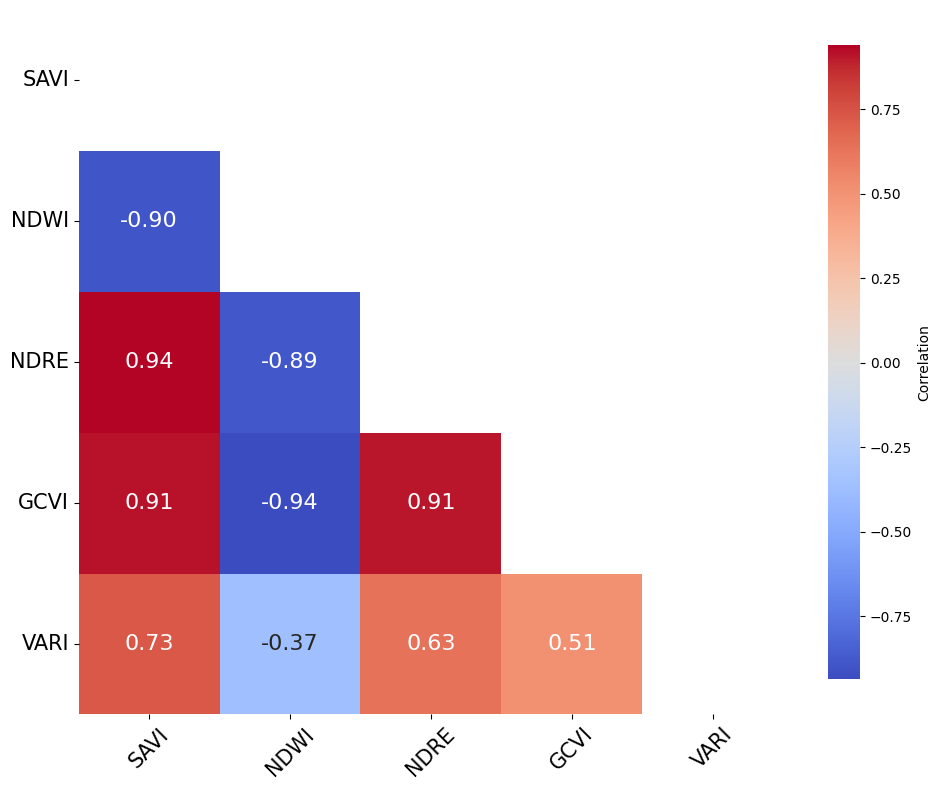

Pares de bandas altamente correlacionadas (umbral > 0.95):


In [ ]:
import itertools

# Suponiendo que ya tenemos las siguientes variables definidas:
# - X_sequences: con forma (n_imágenes, n_bandas_total, alto, ancho)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas_total, n_imágenes)

# Update the band labels, excluding 'Julian Days'
band_labels = ['SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI']

# Verify that X_flat_valid has the correct bands and in the specified order
# Exclude the 'Julian Days' band (assuming it is the first band)

n_valid_pixels, n_bandas_total, n_imágenes = X_flat_valid.shape

# Create an index to select the bands to include (excluding 'Julian Days')
bands_to_include_indices = [i for i in range(n_bandas_total) if i != 0]  # Excluye índice 0

# Select the corresponding bands in X_flat_valid
X_flat_valid_selected = X_flat_valid[:, bands_to_include_indices, :]  # Forma: (n_valid_pixels, n_bandas_seleccionadas, n_imágenes)

# Update n_bands
n_bandas = X_flat_valid_selected.shape[1]

# Transpose and flatten to obtain (n_valid_pixels * n_imágenes, n_bandas)
X_for_corr = X_flat_valid_selected.transpose(0, 2, 1).reshape(-1, n_bandas)

# Replace -1 values with NaN
X_for_corr[X_for_corr == -1] = np.nan

# Remove rows (samples) with NaN values in any band
valid_mask = ~np.isnan(X_for_corr).any(axis=1)
X_for_corr_valid = X_for_corr[valid_mask]

# Calculate the Pearson correlation matrix between the bands
correlation_matrix = np.corrcoef(X_for_corr_valid, rowvar=False)

# Create a mask to show only the lower half of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualize the correlation matrix with the mask applied
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=band_labels, yticklabels=band_labels, center=0, square=True,
            annot_kws={"size": 16},  # Size of the correlation numbers
            cbar_kws={'label': 'Correlation', 'shrink': 0.9, 'orientation': 'vertical'})  # Ajuste del colorbar

# Additional settings for element sizes
plt.title('', fontsize=16)  # Tamaño del título
plt.xticks(rotation=45, fontsize=15)  # Tamaño y rotación de etiquetas del eje X
plt.yticks(rotation=0, fontsize=15)   # Tamaño de etiquetas del eje Y
plt.tight_layout()  # Ajuste de la disposición

# Show the plot
plt.show()

# Define correlation threshold
correlation_threshold = 0.95

# Find pairs of bands with high correlation
highly_correlated_pairs = []
for i, j in itertools.combinations(range(n_bandas), 2):
    corr_value = correlation_matrix[i, j]
    if abs(corr_value) > correlation_threshold:
        highly_correlated_pairs.append((i, j, corr_value))

# Print highly correlated band pairs
print("Pares de bandas altamente correlacionadas (umbral > 0.95):")
for i, j, corr_value in highly_correlated_pairs:
    print(f"{band_labels[i]} y {band_labels[j]}: correlación = {corr_value:.4f}")




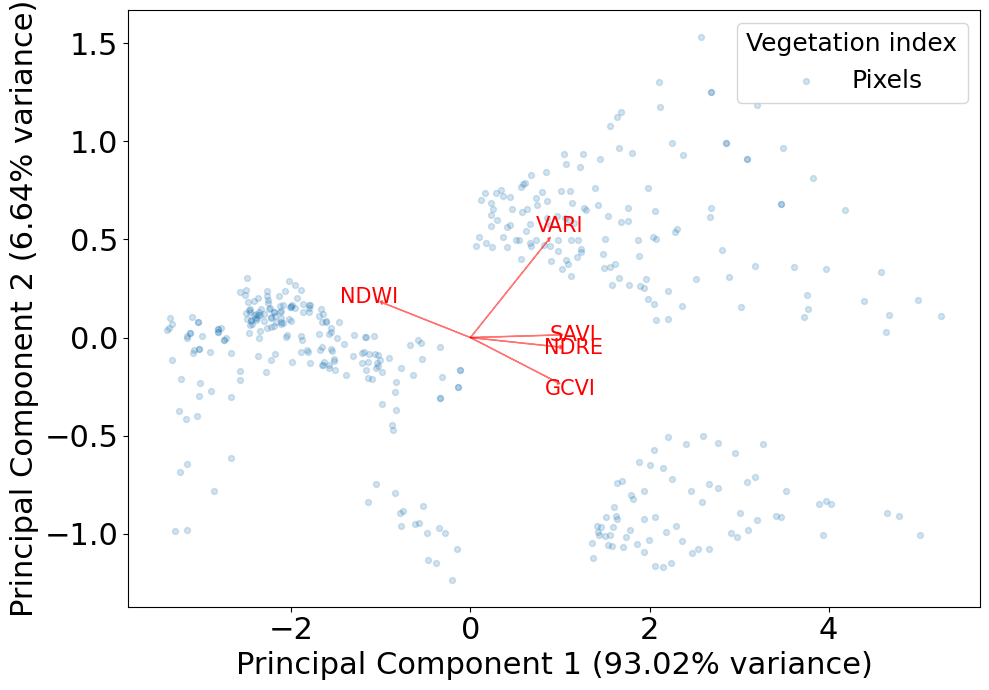

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes las siguientes variables definidas:
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas_total, n_imágenes)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)

# Update the band labels, excluding 'Julian Days'
band_labels = ['SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI']

# Verify that X_flat_valid has the correct bands and in the specified order
# Exclude the 'Julian Days' band (assuming it is the first band)

n_valid_pixels, n_bandas_total, n_imágenes = X_flat_valid.shape

# Create an index to select the bands to include (excluding 'Julian Days')
bands_to_include_indices = [i for i in range(n_bandas_total) if i != 0]  # Exclude index 0

# Select the corresponding bands in X_flat_valid
X_flat_valid_selected = X_flat_valid[:, bands_to_include_indices, :]  # Forma: (n_valid_pixels, n_bandas_seleccionadas, n_imágenes)

# Update n_bandas
n_bandas = X_flat_valid_selected.shape[1]

# Step 1: Average the bands over time to reduce dimensionality
# This will give us a matrix of shape (n_valid_pixels, n_bands)
X_mean_time = np.mean(X_flat_valid_selected, axis=2)  # Average along the time dimension

# Replace -1 values with NaN
X_mean_time[X_mean_time == -1] = np.nan

# Step 2: Remove samples with missing or invalid values
valid_mask = ~np.isnan(X_mean_time).any(axis=1)
X_mean_time_valid = X_mean_time[valid_mask]

# Step 3: Scale the data before PCA (zero mean and unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mean_time_valid)

# Step 4: Perform PCA
n_components = 2  # For the biplot, we need two principal components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Get the percentage of variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Step 5: Obtain the loadings of the original variables
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Step 6: Create the biplot
plt.figure(figsize=(10, 7))

# Plot the scores (projections of the samples on the principal components)
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.2, s=18, label='Pixels')

# Add vectors for the original variables (loadings)
for i, (loading_x, loading_y) in enumerate(loadings):
    plt.arrow(0, 0, loading_x, loading_y, color='red', alpha=0.5, head_width=0.02)
    plt.text(loading_x * 1.15, loading_y * 1.15, band_labels[i], color='red', ha='center', va='center', fontsize=15)

# Update axis labels to include the percentage of variance explained
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2f}% variance)', fontsize=22)
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2f}% variance)', fontsize=22)

# Adjust title size and add one (if needed)
plt.title('', fontsize=16)

# Configure legend
plt.legend(title='Vegetation index', fontsize=18, title_fontsize='18', loc='upper right')

# Additional adjustments to improve visualization
plt.grid(False)  # Optional: disable the grid
plt.xticks(fontsize=22)  # Size of X-axis labels
plt.yticks(fontsize=22)  # Size of Y-axis labels
plt.tight_layout()  # Adjust layout

# Show the plot
plt.show()

In [ ]:
import torch
from torchviz import make_dot
import torch.nn as nn
# Define the custom dataset
class PixelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert to tensors and adjust dimensions to be compatible with the model
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        X = X.unsqueeze(-1).unsqueeze(-1)  # Add fake spatial dimensions (1x1)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

# Define the 3D CNN Pixel-to-Pixel model without normalization layers
class CNN3DModelPixelwise(nn.Module):
    def __init__(self, num_bands, num_images, dropout_rate=0.1):
        super(CNN3DModelPixelwise, self).__init__()

        # Convolutional layers adjusted for 1x1 spatial dimensions
        self.conv1 = nn.Conv3d(in_channels=num_bands, out_channels=32,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv1b = nn.Conv3d(in_channels=32, out_channels=32,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2b = nn.Conv3d(in_channels=64, out_channels=64,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        # Temporal convolution layer to condense temporal information
        self.conv_temporal = nn.Conv3d(in_channels=64, out_channels=64,
                                       kernel_size=(num_images, 1, 1))
        # Final convolution layer
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=1)

        # Dropout for regularization
        self.dropout = nn.Dropout3d(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)

        x = torch.relu(self.conv1b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv_temporal(x))
        x = self.dropout(x)

        x = self.conv3(x)
        x = x.squeeze()
        return x


In [ ]:

x = x = torch.randn(1, num_bands, num_images, 3, 3)  
model = CNN3DModelPixelwise(num_bands, num_images)

# Use the tensor in the model 
y = model(x)

# Create the plot of the arquitecture
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('cnn3d_model')

'cnn3d_model.png'

In [ ]:
# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# División en datos de entrenamiento y prueba, especificando el grupo a dejar fuera
X = X_flat_valid
y = y_flat_valid
groups = location_flat_valid.astype(int)

# Specify the group you want to leave out as the test set
test_group = 3  # Change to the group that you want to leave out

# Create masks to separate the data
train_mask = groups != test_group
test_mask = groups == test_group

# Split the data into training and test sets based on the masks
X_train = X[train_mask]
y_train = y[train_mask]
groups_train = groups[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
groups_test = groups[test_mask]

print(f"Número de muestras en entrenamiento: {len(X_train)}")
print(f"Número de muestras en prueba (grupo {test_group}): {len(X_test)}")
print(f"Grupos en entrenamiento: {np.unique(groups_train)}")
print(f"Grupos en prueba: {np.unique(groups_test)}")


Usando el dispositivo: cpu
Número de muestras en entrenamiento: 496
Número de muestras en prueba (grupo 3): 29
Grupos en entrenamiento: [1 2 4 5]
Grupos en prueba: [3]


In [ ]:
from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import GroupKFold

# Define the hyperparameter grid for tuning / Here we add many other values but this was the best options that we found
# And also for the optimizers 
param_grid = {
    'learning_rate': [0.08, 0.05, 0.1, 0.001],
    'dropout_rate': [0.01, 0.1],
    'optimizer': ['Adam', 'Adagrad']
}

grid = list(ParameterGrid(param_grid))

# Get the unique values of y_train and y_test
unique_y_train = np.unique(y_train)
unique_y_test = np.unique(y_test)

print("Valores únicos en y_train:", unique_y_train)
print("Valores únicos en y_test:", unique_y_test)

# Cross-validation k-fold on training data
unique_groups = np.unique(groups_train)
n_splits = min(4, len(unique_groups))
random_state = 42

Valores únicos en y_train: [55. 78. 84. 88.]
Valores únicos en y_test: [89.]


In [ ]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=n_splits)

grid = list(ParameterGrid(param_grid))

# Variables para almacenar los mejores hiperparámetros y score
best_params = None
best_score = np.inf  # Porque queremos minimizar el RMSE

for params in grid:
    print(f"\nEvaluating hyperparameters: {params}")
    fold_metrics = []

    # Configure the current hyperparameters
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    for fold, (train_idx_fold, val_idx_fold) in enumerate(gkf.split(X_train, y_train, groups=groups_train)):
        print(f"  Fold {fold + 1}/{n_splits}")
        print(f"    Número de muestras en entrenamiento: {len(train_idx_fold)}")
        print(f"    Número de muestras en validación: {len(val_idx_fold)}")

        # Check that the validation set is not empty
        if len(val_idx_fold) == 0:
            print(f"    Fold {fold + 1} skipped due to lack of validation samples.")
            continue

        # Split the data into training and validation
        X_fold_train, X_fold_val = X_train[train_idx_fold], X_train[val_idx_fold]
        y_fold_train, y_fold_val = y_train[train_idx_fold], y_train[val_idx_fold]

        # Normalize the data based on X_fold_train
        num_bands = X_fold_train.shape[1]
        num_images = X_fold_train.shape[2]

        means = np.mean(X_fold_train, axis=(0, 2))
        stds = np.std(X_fold_train, axis=(0, 2))
        stds[stds == 0] = 1  # Avoid division by zero

        def normalize_data(X, means, stds):
            return (X - means[np.newaxis, :, np.newaxis]) / stds[np.newaxis, :, np.newaxis]

        X_fold_train_norm = normalize_data(X_fold_train, means, stds)
        X_fold_val_norm = normalize_data(X_fold_val, means, stds)

        # Create datasets and dataloaders
        train_dataset = PixelDataset(X_fold_train_norm, y_fold_train)
        val_dataset = PixelDataset(X_fold_val_norm, y_fold_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Definir el modelo con los hiperparámetros actuales
        model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

        #  Define the loss and the optmizer 
        criterion = nn.L1Loss()
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

        # Entrenar el modelo en X_fold_train
        num_epochs = 60  # Ajusta según sea necesario
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the training set to calculate R²
        model.eval()
        all_train_preds = []
        all_train_trues = []
        with torch.no_grad():
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_train_preds.extend(preds)
                all_train_trues.extend(trues)

        # Evaluate the model on the validation set
        all_val_preds = []
        all_val_trues = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_val_preds.extend(preds)
                all_val_trues.extend(trues)

        # Calculate metrics for the validation set
        if len(all_val_trues) > 0:
            val_rmse = np.sqrt(mean_squared_error(all_val_trues, all_val_preds))
            val_mae = mean_absolute_error(all_val_trues, all_val_preds)
            val_bias = np.mean(np.array(all_val_preds) - np.array(all_val_trues))
            val_pbias = 100 * np.sum(np.array(all_val_preds) - np.array(all_val_trues)) / np.sum(np.array(all_val_trues))
        else:
            val_rmse = np.nan
            val_mae = np.nan
            val_bias = np.nan
            val_pbias = np.nan

        print(f"    RMSE en validación: {val_rmse:.4f}")
        print(f"    MAE en validación: {val_mae:.4f}")
        print(f"    Bias en validación: {val_bias:.4f}")
        print(f"    PBIAS en validación: {val_pbias:.4f}%")

        # Store the metrics for this fold
        fold_metric = {
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_bias': val_bias,
            'val_pbias': val_pbias
        }
        fold_metrics.append(fold_metric)

    # Calculate the average metrics across all folds
    mean_metrics = {
        'mean_val_rmse': np.nanmean([m['val_rmse'] for m in fold_metrics]),
        'mean_val_mae': np.nanmean([m['val_mae'] for m in fold_metrics]),
        'mean_val_bias': np.nanmean([m['val_bias'] for m in fold_metrics]),
        'mean_val_pbias': np.nanmean([m['val_pbias'] for m in fold_metrics]),
    }

    # Print the average metrics
    print(f"Resultados promedio para los hiperparámetros {params}:")
    print(f"  RMSE promedio en validación: {mean_metrics['mean_val_rmse']:.4f}")
    print(f"  MAE promedio en validación: {mean_metrics['mean_val_mae']:.4f}")
    print(f"  Bias promedio en validación: {mean_metrics['mean_val_bias']:.4f}")
    print(f"  PBIAS promedio en validación: {mean_metrics['mean_val_pbias']:.4f}%")

    # Update the best hyperparameters if needed
    if mean_metrics['mean_val_rmse'] < best_score:
        best_score = mean_metrics['mean_val_rmse']
        best_params = params

print(f"\nMejores hiperparámetros encontrados: {best_params} con RMSE promedio en validación de {best_score:.4f}")


Epoch 1/60, Loss: 33.5427
Epoch 2/60, Loss: 13.3582
Epoch 3/60, Loss: 8.8979
Epoch 4/60, Loss: 8.7922
Epoch 5/60, Loss: 7.2690
Epoch 6/60, Loss: 10.0641
Epoch 7/60, Loss: 6.4320
Epoch 8/60, Loss: 6.8115
Epoch 9/60, Loss: 6.5910
Epoch 10/60, Loss: 5.5201
Epoch 11/60, Loss: 6.2504
Epoch 12/60, Loss: 5.9560
Epoch 13/60, Loss: 6.6240
Epoch 14/60, Loss: 7.3822
Epoch 15/60, Loss: 6.1090
Epoch 16/60, Loss: 8.1923
Epoch 17/60, Loss: 5.2594
Epoch 18/60, Loss: 4.8936
Epoch 19/60, Loss: 4.4764
Epoch 20/60, Loss: 5.1989
Epoch 21/60, Loss: 4.2566
Epoch 22/60, Loss: 3.9348
Epoch 23/60, Loss: 3.8316
Epoch 24/60, Loss: 3.7124
Epoch 25/60, Loss: 4.3831
Epoch 26/60, Loss: 4.5930
Epoch 27/60, Loss: 3.9912
Epoch 28/60, Loss: 4.2271
Epoch 29/60, Loss: 3.6369
Epoch 30/60, Loss: 3.9882
Epoch 31/60, Loss: 4.5181
Epoch 32/60, Loss: 4.6177
Epoch 33/60, Loss: 3.6153
Epoch 34/60, Loss: 3.5675
Epoch 35/60, Loss: 3.9316
Epoch 36/60, Loss: 3.5929
Epoch 37/60, Loss: 4.2302
Epoch 38/60, Loss: 5.3718
Epoch 39/60, Loss:

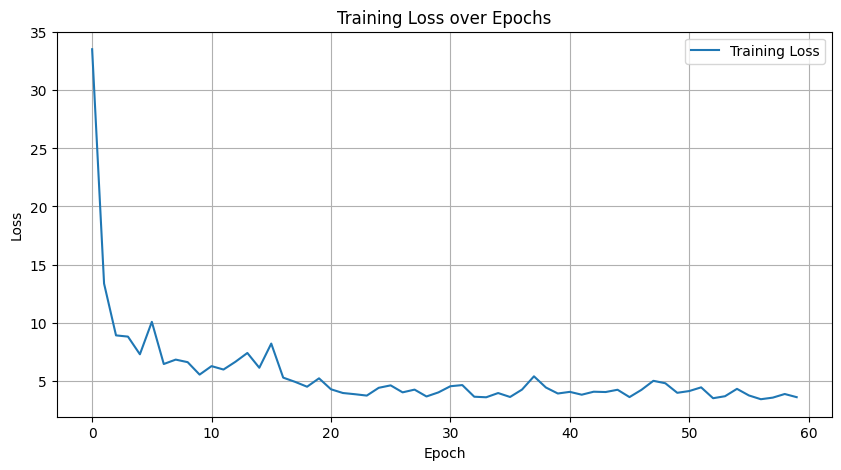

In [ ]:
# Normalize the full training data
num_bands = X_train.shape[1]
num_images = X_train.shape[2]

means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
stds[stds == 0] = 1

def normalize_data(X, means, stds):
    return (X - means[np.newaxis, :, :]) / stds[np.newaxis, :, :]

X_train_norm = normalize_data(X_train, means, stds)

# Create the dataset and dataloader for the full training data
train_dataset = PixelDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Create the model with the best hyperparameters
dropout_rate = 0.01
learning_rate = 0.01
optimizer_name = best_params['optimizer']

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

# Define the loss function and optimizer with the best hyperparameters
criterion = nn.L1Loss()
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 60   # Adjust as needed
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Evaluate the model on the full training set
model.eval()
all_train_preds = []
all_train_trues = []

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        all_train_preds.extend(outputs.cpu().numpy())
        all_train_trues.extend(targets.cpu().numpy())

# Calculate metrics on the full training set
train_mse = mean_squared_error(all_train_trues, all_train_preds)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(all_train_trues, all_train_preds)
train_r2 = r2_score(all_train_trues, all_train_preds)
train_bias = np.mean(np.array(all_train_preds) - np.array(all_train_trues))
train_pbias = 100 * np.sum(np.array(all_train_preds) - np.array(all_train_trues)) / np.sum(np.array(all_train_trues))

print('\nMétricas en el Conjunto de Entrenamiento:')
print(f'RMSE: {train_rmse:.4f}')
print(f'MAE: {train_mae:.4f}')
print(f'R²: {train_r2:.4f}')
print(f'Bias: {train_bias:.4f}')
print(f'PBIAS: {train_pbias:.4f}%')

# Plot the loss function during training
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame with the observed and predicted values of the test set
df_test_results = pd.DataFrame({
    'Valores Observados': np.array(all_train_trues).reshape(-1),
    'Valores Predichos': np.array(all_train_preds).reshape(-1)
})

# Path to save the file
excel_test_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_training_planet.xlsx'

# Save the dataframe in one file
df_test_results.to_excel(excel_test_file_path, index=False)

print(f"Resultados del conjunto de prueba exportados exitosamente a {excel_test_file_path}")

Resultados del conjunto de prueba exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_training_planet.xlsx


R²: 0.7564
RMSE: 5.3167
MAE: 2.3756
Bias: -0.0482
PBIAS: -0.0622%
Pearson Correlation: 0.8701


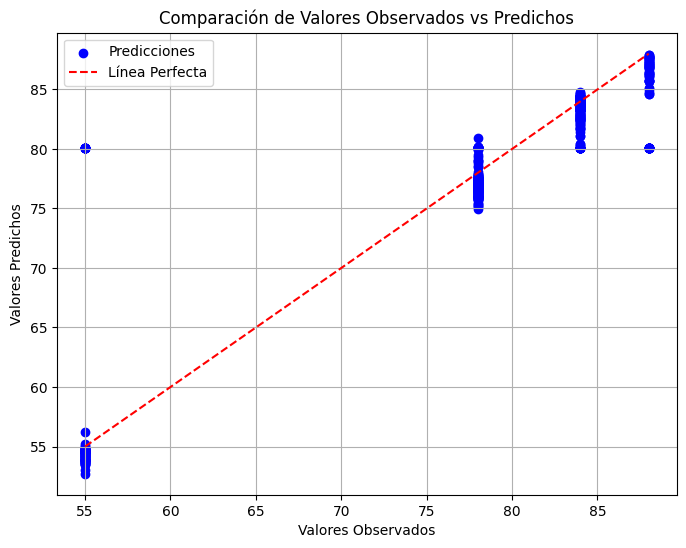

In [ ]:
# Specify the path to the Excel file
excel_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_training_planet.xlsx'

# Read the Excel file
df_results = pd.read_excel(excel_file_path)

# Extract observed and predicted values
observed_values = df_results['Valores Observados']
predicted_values = df_results['Valores Predichos']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

# Calculate MAE
mae = mean_absolute_error(observed_values, predicted_values)

# Calculate R²
r2 = r2_score(observed_values, predicted_values)

# Calculate Bias
bias = np.mean(predicted_values - observed_values)

# Calculate PBIAS
pbias = 100 * np.sum(predicted_values - observed_values) / np.sum(observed_values)

# Calculate Pearson Correlation
pearson_corr, _ = pearsonr(observed_values, predicted_values)

# Display the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Bias: {bias:.4f}")
print(f"PBIAS: {pbias:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Generate the observed vs predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(observed_values, predicted_values, label='Predicciones', color='blue')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', label='Línea Perfecta', linestyle='--')

plt.title('Comparación de Valores Observados vs Predichos')
plt.xlabel('Valores Observados')
plt.ylabel('Valores Predichos')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Final evaluation on the test set
# Normalize the test data using the training data statistics
X_test_norm = normalize_data(X_test, means, stds)

# Create the dataset and dataloader for the test data
test_dataset = PixelDataset(X_test_norm, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test data
model.eval()

all_test_predictions = []
all_test_true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        preds = outputs.cpu().numpy()
        trues = targets.cpu().numpy()

        all_test_predictions.extend(preds)
        all_test_true_values.extend(trues)

# Calculate metrics on the test data
mse = mean_squared_error(all_test_true_values, all_test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_test_true_values, all_test_predictions)
r2 = r2_score(all_test_true_values, all_test_predictions)
bias = np.mean(np.array(all_test_predictions) - np.array(all_test_true_values))
pbias = 100 * np.sum(np.array(all_test_predictions) - np.array(all_test_true_values)) / np.sum(np.array(all_test_true_values))


print('\nMétricas en el Conjunto de Prueba:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'Bias: {bias:.4f}')
print(f'PBIAS: {pbias:.4f}%')


Métricas en el Conjunto de Prueba:
RMSE: 9.4575
MAE: 9.4378
R²: 0.0000
Bias: -9.4378
PBIAS: -10.6043%


In [ ]:
# Create a DataFrame with the observed and predicted values from the test set
df_test_results = pd.DataFrame({
    'Valores Observados': np.array(all_test_predictions).reshape(-1),
    'Valores Predichos': np.array(all_test_true_values).reshape(-1)
})

# Specify the path and name of the Excel file for the test set
excel_test_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_planet.xlsx'

# Save the DataFrame to an Excel file
df_test_results.to_excel(excel_test_file_path, index=False)

print(f"Resultados del conjunto de prueba exportados exitosamente a {excel_test_file_path}")


Resultados del conjunto de prueba exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_planet.xlsx


In [ ]:
# Save the model
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_planet.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'means': means,
    'stds': stds,
    'num_bands': num_bands,
    'num_images': num_images,
    'best_params': best_params
}, model_path)

print(f"\nModelo final guardado en {model_path}")


Modelo final guardado en /content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_planet.pth


In [ ]:
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_planet.pth"

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images).to(device)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
means = checkpoint['means']
stds = checkpoint['stds']
num_bands = checkpoint['num_bands']
num_images = checkpoint['num_images']
model.eval()  

<ipython-input-18-c2c36488d5af>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


CNN3DModelPixelwise(
  (conv1): Conv3d(6, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv1b): Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2): Conv3d(32, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2b): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv_temporal): Conv3d(64, 64, kernel_size=(52, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (dropout): Dropout3d(p=0.1, inplace=False)
)

Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-07-09.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-08-31.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-09-23.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-09-28.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-01.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-10.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-19.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_images/Planet_Image_2022-10-27.tif
Cargando imagen completa para predicción: /content/drive/MyDrive/TF_data/Planet_

<ipython-input-19-1a52794a9967>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Imagen predicha guardada en /content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_planet.tif


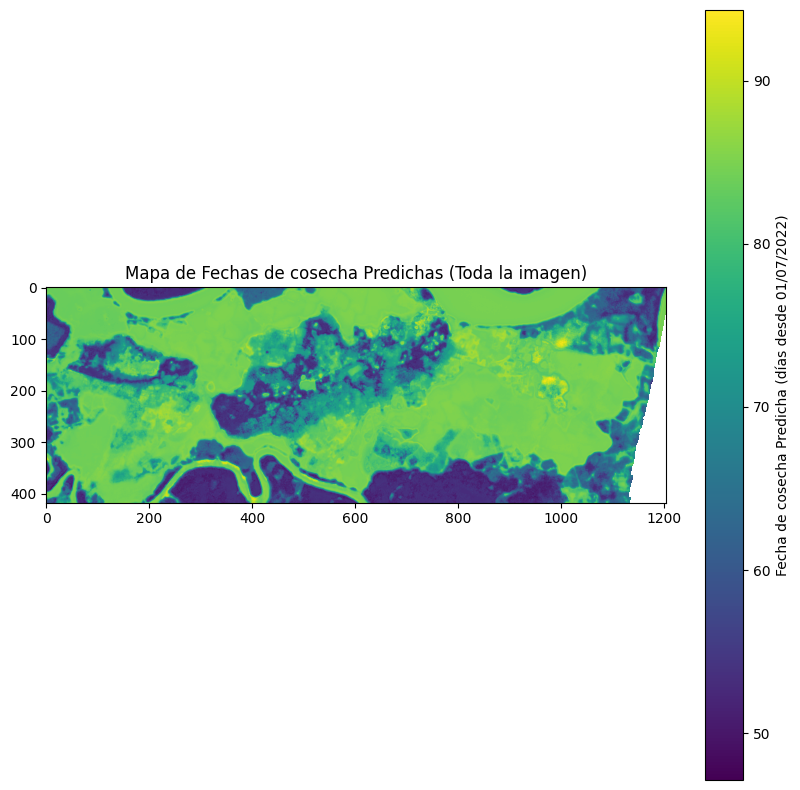

In [ ]:
# Load the full image for prediction
def load_full_sequence_images(image_paths, target_band_names=['dias_julianos', 'SAVI', 'NDWI', 'NDRE', 'GCVI', 'VARI']):
    sequence = []
    if len(image_paths) == 0:
        print("No se encontraron imágenes para el año especificado.")
        return None

    for image_path in image_paths:
        print(f"Cargando imagen completa para predicción: {image_path}")

        # Extract the date from the image file name
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)  # Remove the extension (.tif)
        parts = filename_no_ext.split('_')

        if len(parts) < 3:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        # Extract the date from the image
        image_date_str = parts[2]  # This should contain the date, e.g., '2022-09-23'

        try:
            # Convert the date string to a datetime object
            image_date = datetime.strptime(image_date_str, '%Y-%m-%d')
            # Calculate Julian days
            julian_days = (image_date - base_date).days
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        with rasterio.open(image_path) as src:
            band_names = src.descriptions
            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])  # Skip 'dias_julianos' when selecting bands
            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[selected_bands == -9999] = np.nan  # Keep NaNs if needed

                # Create a Julian days band with the same spatial size as the images
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenate the Julian days band with the selected bands
                stacked_bands = np.vstack((julian_band, selected_bands))

                sequence.append(stacked_bands)
            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        return np.stack(sequence, axis=0)  # (n_imágenes, n_bandas, alto, ancho)
    else:
        print("No se pudo cargar ninguna imagen.")
        return None

# Load the full image for prediction
X_full_sequences = load_full_sequence_images(image_paths_in_range)

# Check that the sequences were loaded
if X_full_sequences is not None:
    print(f"Shape de X_full_sequences: {X_full_sequences.shape}")  # (n_imágenes, n_bandas, alto, ancho)
else:
    raise ValueError("No se pudieron cargar las secuencias de imágenes completas.")

# Rearrange the data to match the model format
# Transpose to (n_bandas, n_imágenes, alto, ancho)
X_full = X_full_sequences.transpose(1, 0, 2, 3)
X_full = X_full.astype(np.float32)

# Normalize the full image using the means and standard deviations from the trained model
def normalize_dataset(X_data, means, stds):
    return (X_data - means[:, :, np.newaxis, np.newaxis]) / stds[:, :, np.newaxis, np.newaxis]

X_full_norm = normalize_dataset(X_full, means, stds)

# Flatten the spatial dimensions to obtain a list of pixels
X_full_flat = X_full_norm.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_pixels, num_bands, num_imágenes)

print(f"Shape de X_full_flat: {X_full_flat.shape}")  # (n_pixels, num_bands, num_imágenes)

# Create a Dataset and DataLoader for full prediction
full_dataset = PixelDataset(X_full_flat, np.zeros(X_full_flat.shape[0]))  # Labels are irrelevant here
full_loader = DataLoader(full_dataset, batch_size=24, shuffle=False)

# Load the trained model
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Apply the trained model to the entire image
all_predictions = []

with torch.no_grad():
    for inputs, _ in full_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.cpu().numpy()
        all_predictions.extend(preds)

# Reconstruct the prediction image
predictions_array = np.array(all_predictions)
height, width = X_full_sequences.shape[2], X_full_sequences.shape[3]
predictions_image = predictions_array.reshape(height, width)

# Save the predicted image
with rasterio.open(image_paths_in_range[0]) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32, count=1)

output_path = '/content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_planet.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(predictions_image, 1)

print(f"Imagen predicha guardada en {output_path}")

# Visualize the predicted image
plt.figure(figsize=(10, 10))
plt.imshow(predictions_image, cmap='viridis')
plt.colorbar(label='Fecha de cosecha Predicha (días desde 01/07/2022)')
plt.title('Mapa de Fechas de cosecha Predichas (Toda la imagen)')
plt.show()